# Standard Kalman filter (4F7)

In [2]:
import torch
import matplotlib.pyplot as plt

from purias_utils.ssm.process.linear import LinearStateSpaceModel
from purias_utils.ssm.process.noise import WhiteNoise
from purias_utils.ssm.process.base import FlatProcess, ProcessGroup

Standard 2D movement, with acceleration in each direction drawn from Brownian motion

State: $\boldsymbol x = (x, y, \dot x, \dot y)$

In [9]:
device = 'cpu'

dt = 0.005

dynamics_matrix_process = FlatProcess(torch.tensor(
    [
        [1., 0., dt, 0.],       # x  = x + x' dt + ...
        [0., 1., 0., dt],
        [0., 0., 1., 0.],       # x' = x' + ...
        [0., 0., 0., 1.],
    ]
))

input_dynamics_matrix = 3 * torch.tensor(   # 3 times for good measure!
    [
        [0.5*dt**2,  0.],        # ... 0.5 x'' dt^2
        [0., 0.5*dt**2.],
        [dt,         0.],        # ... x'' dt
        [0.,         dt],
    ]
)

# Convert the input_dynamics_matrix into a covariance for our white noise
random_acceleration_cholesky = torch.linalg.cholesky(
    (torch.eye(4) * 1e-11) + (input_dynamics_matrix @ input_dynamics_matrix.T)
)
random_acceleration_process = WhiteNoise(
    N_matrix = random_acceleration_cholesky, output_magnitude=1.0, device = device
)

state_process = LinearStateSpaceModel(
    dynamics_matrix_process = dynamics_matrix_process,
    noise_process = random_acceleration_process,
    value_offset_process = FlatProcess(0.0),
    input_process = FlatProcess(0.0)
)

# Only view the location part of the state
state_only_viewer_process = FlatProcess(torch.tensor(
    [
        [1., 0., 0., 0.],
        [0., 1., 0., 0.]
    ]
))

observation_noise_process = WhiteNoise(
    N_matrix = 0.1 * torch.eye(2),
    output_magnitude=1.0, 
    device = device
)

observation_process = (state_only_viewer_process @ state_process) + observation_noise_process

random_acceleration_process.reinitialise(random_acceleration_process.N_matrix @ torch.randn(4))
state_process.reinitialise(torch.zeros(4))
observation_noise_process.reinitialise(torch.zeros(2))


pre_update_processes = ProcessGroup([
    dynamics_matrix_process,
    state_only_viewer_process
])


post_update_processes = ProcessGroup([
    random_acceleration_process,
    state_process,
    observation_noise_process,
    observation_process
])

Now we can infer states with the Kalman filter

In [10]:
from purias_utils.ssm.kalman_filter import NonBayesianKalmanFilter
from tqdm import tqdm

100%|██████████| 500/500 [00:00<00:00, 4023.18it/s]


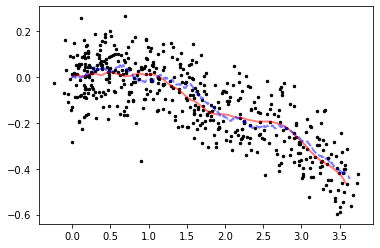

In [11]:

trace = []
observations = []
estimations = []

kalman_filter = NonBayesianKalmanFilter(
    initial_estimate = state_process.previous_value,
    initial_state_estimate_covariance = torch.zeros(state_process.previous_value.shape[0], state_process.previous_value.shape[0]),
    fn_process = dynamics_matrix_process,
    gn_process = state_only_viewer_process,
    qn_process = random_acceleration_process,
    rn_process = observation_noise_process,
    observation_process = observation_process,
)

for i in tqdm(range(500)):

    pre_update_processes()

    kalman_filter.pre_update_step()

    post_update_processes()

    kalman_filter.post_update_step()

    trace.append(state_process.previous_value[:2])
    observations.append(observation_process.previous_value)
    estimations.append(kalman_filter.state_estimate[:2])

plt.plot(*torch.stack(trace, 1).numpy(), linewidth = 2, color = 'red', alpha = 0.5)
plt.scatter(*torch.stack(observations, 1).numpy(), s = 6, color = 'black')
plt.plot(*torch.stack(estimations, 1).numpy(), linewidth = 2, color = 'blue', linestyle='--', alpha = 0.5)
